In [56]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

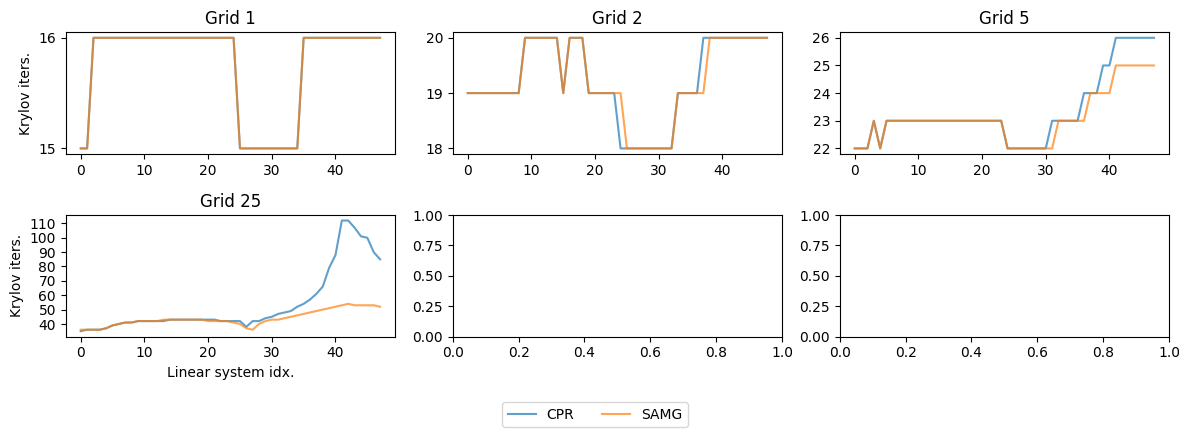

In [60]:
grids = [
    1,
    2,
    5,
    25,
    # 33,
    # 40,
]

# s = 1
solvers = [
    "CPR",
    "SAMG",
    # "S4_diag",
    # "SAMG+ILU",
    # "S4_diag+ILU",
    # "AAMG+ILU",
]
colors = {name: f"C{i}" for i, name in enumerate(solvers)}

data = {}
names = {}
for i, g in enumerate(grids):
    data[i] = {}
    names[i] = f"Grid {g}"
    for s in solvers:
        try:
            data[i][s] = load_data(f"../stats/stats_thermal_geonofracx{g}_sol{s}.json")
            # data[i]['CPR'] = load_data(f"../stats/stats_thermal_geonofracx{g}_sol{'CPR'}_bcnoflux.json")
        except:
            continue


shape = [2, 3]
figsize = (12, 4)


def render_element(i, data):
    if len(data) == 0:
        return
    for solver_name, d in data.items():
        # color_converged_reason(d, legend=True)
        plt.plot(
            get_gmres_iterations(d), label=solver_name, alpha=0.7, c=colors[solver_name]
        )
        # plt.plot(get_newton_iterations(d), label=solver_name, alpha=0.7)
        # plt.twinx()
        # DAY = 3600 * 24
        # plt.plot(np.cumsum(get_time_steps(d)) / DAY , color='black', alpha=0.5, label='Time')
        # plt.plot(get_time_steps(d), label=solver_name, alpha=0.7, c=colors[solver_name])

    # plt.gca().grid(True)
    set_integer_ticks("vertical")
    # color_time_steps(data["SAMG"], fill=True, grid=False, legend=True)
    # plt.yscale('log')


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

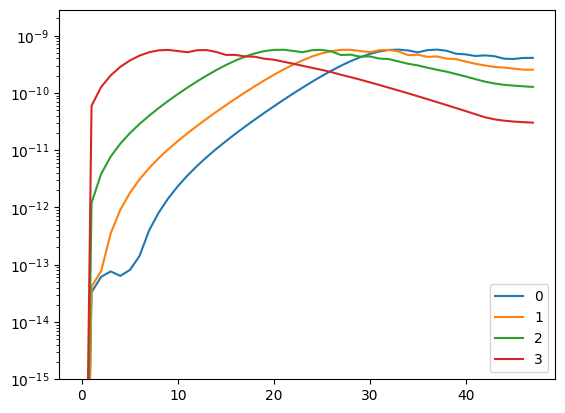

In [61]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    entry = entry.get("CPR")
    if entry is None:
        return
    # color_time_steps(entry, fill=True, grid=False, legend=True)
    cfl = get_cfl(entry)
    enthalpy = get_enthalpy_max(entry)
    fourier = get_fourier_max(entry)
    # plt.plot(enthalpy, label='Convection')
    plt.plot(fourier, label=i)
    plt.yscale("log")
    plt.ylim(bottom=1e-15)

    # peclet = get_peclet_max(entry)
    # peclet = get_peclet_mean(entry)
    # plt.plot(peclet, label=r'$Pe$')
    # plt.plot(cfl, label='CFL')
    # plt.twinx()
    # plt.plot(peclet_max, label=r'$P_{max}$')
    # plt.yscale('log')
    # plt.ylim(bottom=1e-2)
    # plt.twinx()
    # DAY = 3600 * 24
    # plt.plot(np.cumsum(get_time_steps(entry)) / DAY , color='black', alpha=0.5, label='Time')
    # plt.yscale('log')
    # st, sl, op = get_num_sticking_sliding_open(entry)
    # plt.gca().grid(False)
    # plt.gca().grid(True, which="major", axis="y")
    # marker = None
    # plt.plot(st, label="Sticking", marker=marker, color=COLOR_STICKING)
    # plt.plot(sl, label="Sliding", marker=marker, color=COLOR_SLIDING)
    # plt.plot(op, label="Open", marker=marker, color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)

for i, d in data.items():
    render_element(i, d)

plt.legend()


# plot_grid(
#     data,
#     render_element,
#     shape=shape,
#     figsize=figsize,
#     ylabel="num cells",
#     ax_titles=names,
#     #   ylabel="Fract. len., m"
# )
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [62]:
from collections import defaultdict
import pandas as pd

table = dict()

NDIGITS = 3

for g in grids:
    table[g] = {}
    for s in solvers:
        stats_name = f"stats_thermal_geonofracx{g}_sol{s}.json"
        try:
            entry = load_data(f"../stats/{stats_name}")
            dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
        except FileNotFoundError:
            continue
        total_dofs = dofs_info["total dofs"]
        table[g]["Total DoFs"] = str(int(total_dofs))
        table[g][s] = round(np.mean(get_gmres_iterations(entry)), NDIGITS)
        # table[g][s] = (np.sum(get_gmres_iterations(entry)))

        # if g in [1, 2, 5]:
        #     direct = load_data(f"../stats/stats_geo0x{g}_sol{21}_ph{1}_bb{2}_fr{1}.json")
        #     table["GMRES dir."].append(round(np.mean(get_gmres_iterations(direct)), NDIGITS))
        # else:
        #     table["GMRES dir."].append('-')

        # table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))
        converged_reason = get_petsc_converged_reason(entry)
        # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table)
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = "Total DoFs"
table

Total DoFs,1000,3776,23352,578856
CPR,15.75,19.229,23.354,53.792
SAMG,15.75,19.229,23.125,43.833


In [87]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_nofrac import make_model
import porepy as pp

model = make_model(
    {
        "geometry": "nofrac",
        "grid_refinement": 2,
        "solver": 1,
        "save_matrix": False,
        "steady_state": False,
        "initial_state": "ignore",
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 1.00e-03 (days)
Temperature: 0.00, 0.00
Peclet: 1.5e+05, CFL: 3.3e-04
sticking: 0, sliding: 0, open: 0


/home/porepy/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/porepy/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [88]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"),
    30,
)

In [89]:
model.linear_system = mat, rhs
model.bmat.mat = mat
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.ad_time_step.set_value(dt)
model.time_manager.dt = dt
model.discretize()

AssertionError: 

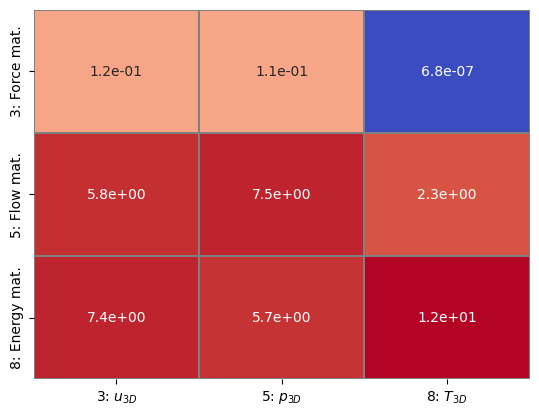

In [90]:
J = model.bmat[:]
J.plot_max()

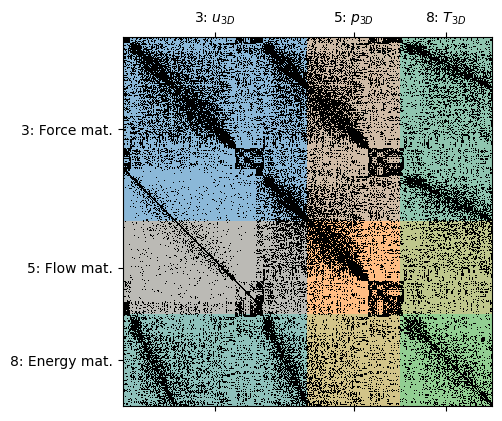

In [91]:
J.color_spy()

ksp_type fgmres
ksp_pc_side right
ksp_rtol 1e-10
ksp_max_it 120
ksp_gmres_cgs_refinement_type refine_ifneeded
ksp_gmres_classicalgramschmidt True
ksp_monitor None
pc_type fieldsplit
pc_fieldsplit_type schur
pc_fieldsplit_schur_precondition user
pc_fieldsplit_schur_fact_type upper
fieldsplit_3-4_ksp_type preonly
fieldsplit_3-4_pc_type hypre
fieldsplit_5-6-7-8-9-10_ksp_type preonly
fieldsplit_3-4_pc_hypre_type boomeramg
fieldsplit_3-4_pc_hypre_boomeramg_strong_threshold 0.7
fieldsplit_3-4_pc_hypre_boomeramg_smooth_type Euclid
fieldsplit_5-6-7-8-9-10_pc_type composite
fieldsplit_5-6-7-8-9-10_pc_composite_type multiplicative
fieldsplit_5-6-7-8-9-10_pc_composite_pcs none,none
fieldsplit_5-6-7-8-9-10_sub_0_pc_type fieldsplit
fieldsplit_5-6-7-8-9-10_sub_0_pc_fieldsplit_type additive
fieldsplit_5-6-7-8-9-10_sub_0_pc_fieldsplit_schur_precondition selfp
fieldsplit_5-6-7-8-9-10_sub_0_pc_fieldsplit_schur_fact_type upper
fieldsplit_5-6-7-8-9-10_sub_0_fieldsplit_5-6-7_ksp_type preonly
fieldsplit_5-6

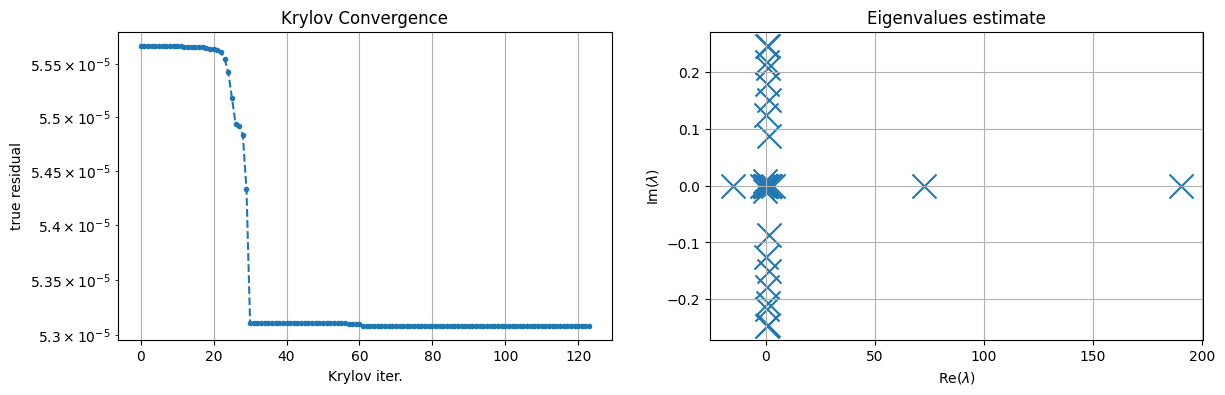

In [ ]:
from fixed_stress import make_fs_analytical_slow_new, make_fs_thermal
from full_petsc_solver import *
from thermal.thm_solver import make_pt_permutation

model = model
contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]

self = model


scheme = LinearTransformedScheme(
    inner=PetscKSPScheme(
        petsc_options={
            "ksp_type": "fgmres",
            "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=mech,
            elim_options=(
                {
                    # "ksp_type": "gmres",
                    # 'ksp_monitor': None,
                    # "ksp_max_it": 120,
                    # 'ksp_rtol': 1e-2,
                    "pc_type": "hypre",
                    "pc_hypre_type": "boomeramg",
                    "pc_hypre_boomeramg_strong_threshold": 0.7,
                    "pc_hypre_boomeramg_smooth_type": "Euclid",
                }
            ),
            keep_options={},
            block_size=self.nd,
            invert=lambda bmat: csr_to_petsc(
                make_fs_analytical_slow_new(
                    self,
                    bmat,
                    p_mat_group=5,
                    p_frac_group=6,
                    groups=flow + temp,
                ).mat,
                bsize=1,
            ),
            complement=PetscCompositeScheme(
                groups=flow + temp,
                solvers=[
                    PetscFieldSplitScheme(
                        groups=flow,
                        fieldsplit_options={
                            "pc_fieldsplit_type": "additive",
                        },
                        elim_options={
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                            # "pc_hypre_boomeramg_smooth_type": "Euclid",
                        },
                        complement=PetscFieldSplitScheme(
                            groups=temp,
                            elim_options={
                                "pc_type": "none",
                            },
                        ),
                    ),
                    PetscFieldSplitScheme(
                        groups=flow + temp,
                        python_pc=lambda bmat: PcPythonPermutation(
                            make_pt_permutation(bmat, p_groups=flow, t_groups=temp),
                            block_size=2,
                        ),
                        elim_options={
                            "python_pc_type": "ilu",
                            # "python_pc_type": "hypre",
                            # "python_pc_hypre_type": "Euclid",
                            # "python_pc_hypre_euclid_bj": True,
                        },
                    ),
                ],
            ),
        ),
    ),
)

ksp = solve_petsc_3(J, rhs, scheme, ksp_view=True, options_view=True, return_data=True)

ksp_type gmres
ksp_pc_side right
ksp_rtol 1e-10
ksp_max_it 120
ksp_gmres_cgs_refinement_type refine_ifneeded
ksp_gmres_classicalgramschmidt True
ksp_monitor None
pc_type fieldsplit
pc_fieldsplit_type schur
pc_fieldsplit_schur_precondition user
pc_fieldsplit_schur_fact_type upper
fieldsplit_3-4_ksp_type preonly
fieldsplit_3-4_pc_type hypre
fieldsplit_5-6-7-8-9-10_ksp_type preonly
fieldsplit_3-4_pc_hypre_type boomeramg
fieldsplit_3-4_pc_hypre_boomeramg_strong_threshold 0.7
fieldsplit_3-4_pc_hypre_boomeramg_nodal_coarsen 4
fieldsplit_3-4_pc_hypre_boomeramg_vec_interp_variant 2
fieldsplit_3-4_pc_hypre_boomeramg_nodal_coarsen_diag 1
fieldsplit_3-4_pc_hypre_boomeramg_vec_interp_qmax 4
fieldsplit_3-4_pc_hypre_boomeramg_vec_interp_smooth 1
fieldsplit_3-4_pc_hypre_boomeramg_interp_refine 1
fieldsplit_5-6-7-8-9-10_pc_type python
fieldsplit_5-6-7-8-9-10_python_pc_type hypre
fieldsplit_5-6-7-8-9-10_python_pc_hypre_type boomeramg
Construction took: 0.02
  0 KSP Residual norm 5.567201039707e-05 
  1

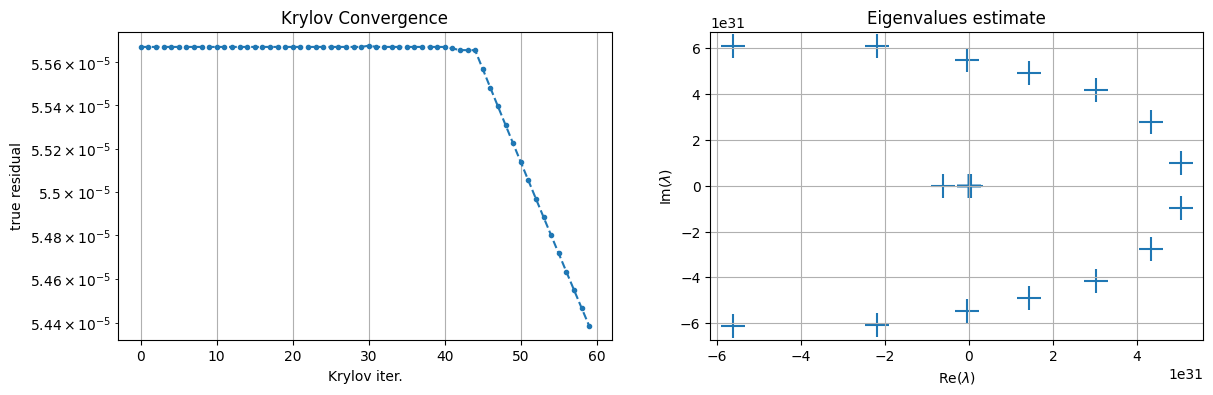

In [ ]:
from hm_solver import build_mechanics_near_null_space


scheme = LinearTransformedScheme(
    inner=PetscKSPScheme(
        petsc_options={
            "ksp_type": "gmres",
            "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=mech,
            # near_null_space=build_mechanics_near_null_space(model),
            elim_options=(
                {
                    "pc_type": "hypre",
                    "pc_hypre_type": "boomeramg",
                    "pc_hypre_boomeramg_strong_threshold": 0.7,
                    # "pc_hypre_boomeramg_smooth_type": "Euclid",
                    "pc_hypre_boomeramg_nodal_coarsen": 4,
                    "pc_hypre_boomeramg_vec_interp_variant": 2,
                    "pc_hypre_boomeramg_nodal_coarsen_diag": 1,
                    "pc_hypre_boomeramg_vec_interp_qmax": 4,
                    "pc_hypre_boomeramg_vec_interp_smooth": 1,
                    "pc_hypre_boomeramg_interp_refine": 1,
                    # 'pc_hypre_boomeramg_nodal_relaxation': 1
                }
            ),
            keep_options={},
            block_size=self.nd,
            invert=lambda bmat: csr_to_petsc(
                make_fs_analytical_slow_new(
                    self,
                    bmat,
                    p_mat_group=5,
                    p_frac_group=6,
                    groups=flow + temp,
                ).mat,
                bsize=1,
            ),
            complement=PetscFieldSplitScheme(
                groups=flow + temp,
                python_pc=lambda bmat: PcPythonPermutation(
                    make_pt_permutation(bmat, p_groups=flow, t_groups=temp),
                    block_size=2,
                ),
                elim_options={
                    "python_pc_type": "hypre",
                    "python_pc_hypre_type": "boomeramg",
                    # 'python_pc_hypre_boomeramg_vec_interp_qmax': 16,
                    # 'python_pc_hypre_boomeramg_relax_type_all': 'l1scaled-Jacobi',
                    # 'python_pc_hypre_boomeramg_grid_sweeps_all': 2,
                    # 'python_pc_hypre_boomeramg_max_row_sum': 1,
                    # "python_pc_hypre_boomeramg_nodal_coarsen": 4,
                    # "python_pc_hypre_boomeramg_vec_interp_variant": 2,
                    # "python_pc_hypre_boomeramg_strong_threshold": 0.7,
                    # 'python_pc_hypre_boomeramg_nodal_coarsen_diag': 1,
                    # 'python_pc_hypre_boomeramg_vec_interp_qmax': 4,
                    # 'python_pc_hypre_boomeramg_vec_interp_smooth': 1,
                    # 'python_pc_hypre_boomeramg_interp_refine': 1,
                    # "python_pc_hypre_boomeramg_smooth_type": "Euclid",
                },
            ),
        ),
    ),
)

ksp = solve_petsc_3(J, rhs, scheme, ksp_view=True, options_view=True, return_data=True)

ksp_type preonly
ksp_pc_side right
ksp_rtol 1e-10
ksp_max_it 120
ksp_gmres_cgs_refinement_type refine_ifneeded
ksp_gmres_classicalgramschmidt True
ksp_monitor None
pc_type hmg
hmg_inner_pc_type hypre
hmg_inner_pc_hypre_type boomeramg
hmg_inner_pc_hypre_boomeramg_strong_threshold 0.7
mg_levels_ksp_type richardson
Construction took: 0.0
  0 KSP Residual norm 5.567201039707e-05 
  1 KSP Residual norm 9.974483420759e-09 
  2 KSP Residual norm 5.331672366296e-10 
  3 KSP Residual norm 2.501338211839e-12 
  4 KSP Residual norm 1.308152759251e-14 
  5 KSP Residual norm 7.947639039236e-17 
Solve  took: 0.0
True residual: 1.4276371705432922e-12
PETSc Converged Reason: 2
KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with one step of iterative refinement when needed
    happy breakdown tolerance 1e-30
  maximum iterations=120, initial guess is zero
  tolerances:  relative=1e-10, absolute=1e-50, divergence=10000.
  right precond

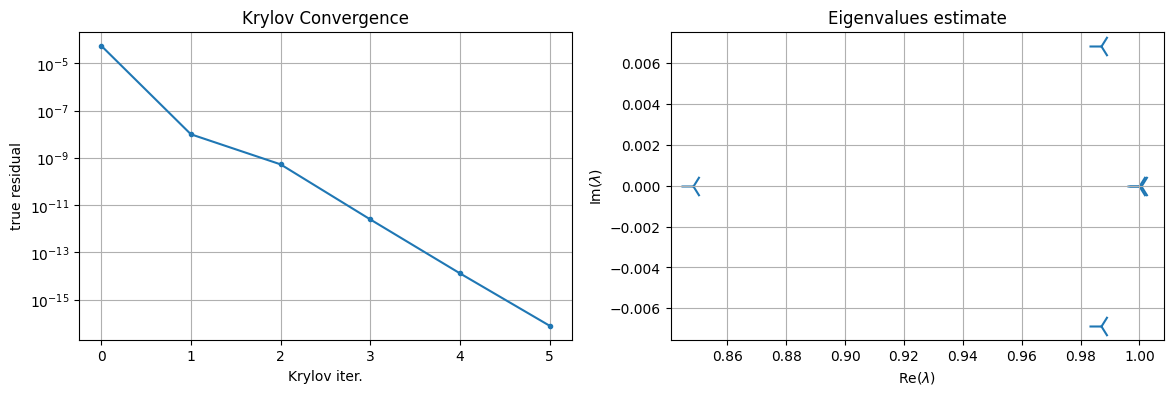

In [ ]:
from hm_solver import build_mechanics_near_null_space


scheme = LinearTransformedScheme(
    inner=PetscKSPScheme(
        petsc_options={
            "ksp_type": "gmres",
            "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=mech,
            block_size=model.nd,
            near_null_space=build_mechanics_near_null_space(model),
            elim_options=(
                {
                    "pc_type": "hmg",  # potentially better (but maybe due to smoothers)
                    "hmg_inner_pc_type": "hypre",
                    "hmg_inner_pc_hypre_type": "boomeramg",
                    "hmg_inner_pc_hypre_boomeramg_strong_threshold": 0.7,
                    "mg_levels_ksp_type": "richardson",
                    #
                    # "pc_type": "hypre",
                    # "pc_hypre_type": "boomeramg",
                    # "pc_hypre_boomeramg_strong_threshold": 0.7,
                    # # # "pc_hypre_boomeramg_smooth_type": "Euclid",
                    # "pc_hypre_boomeramg_nodal_coarsen": 4,
                    # "pc_hypre_boomeramg_vec_interp_variant": 2,
                    # "pc_hypre_boomeramg_nodal_coarsen_diag": 1,
                    # "pc_hypre_boomeramg_vec_interp_qmax": 4,
                    # "pc_hypre_boomeramg_vec_interp_smooth": 1,
                    # 'pc_hypre_boomeramg_nodal_relaxation': 1
                }
            ),
        ),
    ),
)

ksp = solve_petsc_3(J, rhs, scheme, ksp_view=True, options_view=True, return_data=True)

In [7]:
J1.local_dofs_row

NameError: name 'J1' is not defined

In [ ]:
J

In [ ]:
J.groups_to_blocks_row[0]

[]

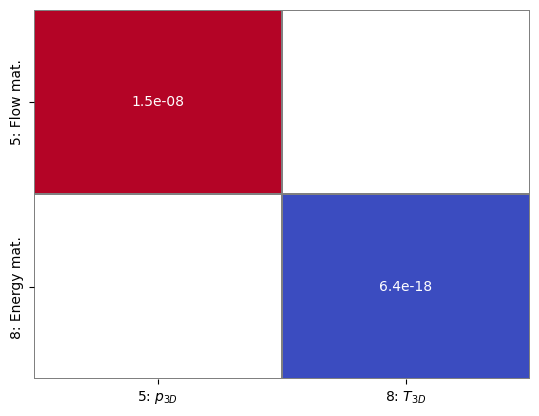

In [ ]:
from fixed_stress import (
    get_fixed_stress_stabilization,
    make_fs_analytical,
    make_fs_thermal,
)
from mat_utils import *
from block_matrix import *


def make_stab(bmat: BlockMatrixStorage, keep: list[int], elim: list[int]):
    stab = bmat[keep].empty_container()
    inv_ = inv_block_diag(bmat[elim].mat, nd=model.nd)
    stab.mat -= bmat[keep, elim].mat @ inv_ @ bmat[elim, keep].mat
    return stab


# elim = [0, 1, 2, 3, 4]
# keep = [5, 6, 8, 9]
p = [5]
T = [8]
elim = [3]
keep = p + T
# stab1 = make_stab(J, elim=elim, keep=keep)
# stab1.set_zeros(p, p)
# stab1.set_zeros(p, T)
# stab1.set_zeros(T, p)
# stab1.set_zeros(T, T)

stab1 = make_fs_thermal(
    model,
    J,
    groups=keep,
    p_mat_group=5,
    p_frac_group=-1,
    t_mat_group=8,
    t_frac_group=-1,
)
stab1.plot_max()

S = J[keep].copy()
S.mat += stab1.mat

ksp_type fgmres
ksp_pc_side right
ksp_rtol 1e-10
ksp_max_it 120
ksp_gmres_cgs_refinement_type refine_ifneeded
ksp_gmres_classicalgramschmidt True
pc_type fieldsplit
pc_fieldsplit_type schur
pc_fieldsplit_schur_precondition user
pc_fieldsplit_schur_fact_type upper
fieldsplit_3-4_ksp_type gmres
fieldsplit_3-4_pc_type hypre
fieldsplit_5-6-7-8-9-10_ksp_type preonly
fieldsplit_3-4_ksp_rtol 0.01
fieldsplit_3-4_ksp_pc_side right
fieldsplit_3-4_pc_hypre_type boomeramg
fieldsplit_3-4_pc_hypre_boomeramg_strong_threshold 0.6
fieldsplit_3-4_pc_hypre_boomeramg_P_max 1
fieldsplit_3-4_pc_hypre_boomeramg_max_iter 1
fieldsplit_3-4_pc_hypre_boomeramg_cycle_type W
fieldsplit_5-6-7-8-9-10_pc_type composite
fieldsplit_5-6-7-8-9-10_pc_composite_type multiplicative
fieldsplit_5-6-7-8-9-10_pc_composite_pcs fieldsplit,ksp
fieldsplit_5-6-7-8-9-10_sub_0_pc_fieldsplit_type additive
fieldsplit_5-6-7-8-9-10_sub_1_ksp_ksp_pc_side right
fieldsplit_5-6-7-8-9-10_sub_1_ksp_ksp_rtol 0.01
fieldsplit_5-6-7-8-9-10_sub_1_ksp

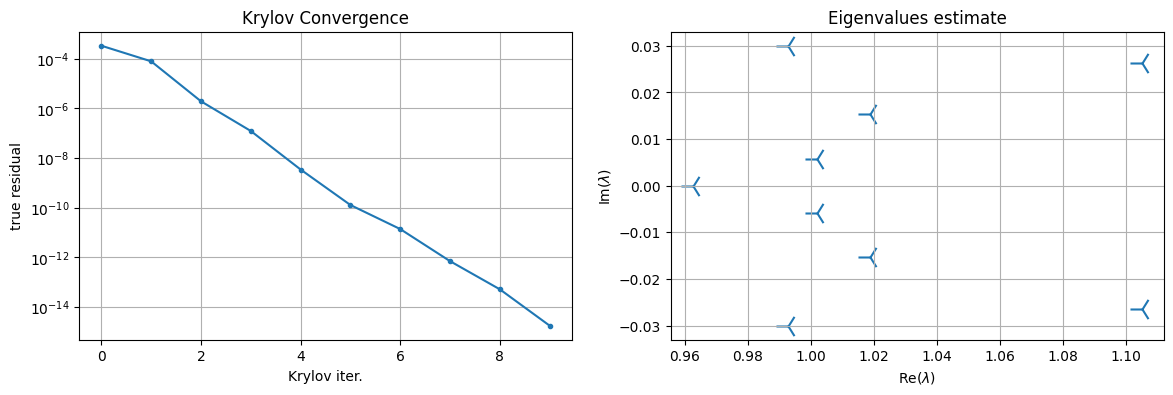

In [ ]:
from fixed_stress import make_fs_thermal
from full_petsc_solver import *

model = model
contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]

scheme = LinearTransformedScheme(
    # right_transformations=[lambda bmat: self.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            "ksp_type": "fgmres",
            # 'ksp_type': 'richardson',
            # 'ksp_pc_side': 'left',
            # "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=mech,
            subsolver_options={
                "ksp_type": "gmres",
                "ksp_rtol": 1e-2,
                "ksp_pc_side": "right",
                # 'ksp_monitor': None,
                # # old
                "pc_type": "hypre",
                "pc_hypre_type": "boomeramg",
                "pc_hypre_boomeramg_strong_threshold": 0.6,
                # not sure:
                "pc_hypre_boomeramg_P_max": 1,
                "pc_hypre_boomeramg_max_iter": 1,
                "pc_hypre_boomeramg_cycle_type": "W",
            },
            tmp_options={
                # 'ksp_type': 'gmres',
                # 'ksp_rtol': 1e-3,
                # 'ksp_pc_side': 'right',
                # 'ksp_monitor': None,
            },
            block_size=model.nd,
            invert=lambda bmat: csr_to_petsc(
                make_fs_thermal(
                    model,
                    bmat,
                    p_mat_group=5,
                    p_frac_group=-1,
                    t_mat_group=8,
                    t_frac_group=-1,
                    groups=flow + temp,
                ).mat
                * 1,
                bsize=1,
            ),
            complement=PetscCPRScheme(
                groups=flow + temp,
                pressure_groups=flow,
                pressure_options={
                    # 'ksp_type': 'gmres',
                    # 'ksp_rtol': 1e-8,
                    # 'ksp_pc_side': 'right',
                    # 'ksp_monitor': None,
                    "pc_type": "hypre",
                    "pc_hypre_type": "boomeramg",
                },
                others_options={
                    "ksp_type": "preonly",
                    "pc_type": "none",
                },
                cpr_options={
                    "pc_composite_pcs": "fieldsplit,ksp",
                    "sub_1_ksp_ksp_pc_side": "right",
                    "sub_1_ksp_ksp_rtol": 1e-2,
                    "sub_1_ksp_pc_type": "hypre",
                    "sub_1_ksp_pc_hypre_type": "Euclid",
                    "sub_1_ksp_ksp_monitor": None,
                    "sub_1_ksp_ksp_max_it": 120,
                    #
                    # "pc_composite_pcs": "fieldsplit,ilu",
                    # "pc_composite_pcs": "fieldsplit,hypre",
                    # 'sub_1_pc_hypre_type': 'Euclid',
                },
            ),
        ),
    ),
)

ksp = solve_petsc_3(J, rhs, scheme, ksp_view=True, options_view=True, return_data=True)

In [ ]:
ksp.ksp